In [1]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="dark")
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn import preprocessing
import cv2
import glob
import os
import warnings as wr

wr.filterwarnings("ignore")



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* Data preprocessing
* feature extraction using VGG-16
* training

# Data preparation

In [3]:
train_path=r'/content/drive/MyDrive/archive/Train/Train/JPEGImages'
train_annot=r'/content/drive/MyDrive/archive/Train/Train/Annotations'

test_path=r'/content/drive/MyDrive/archive/Test/Test/JPEGImages'
test_annot=r'/content/drive/MyDrive/archive/Test/Test/Annotations'

val_path=r'/content/drive/MyDrive/archive/Val/Val/JPEGImages'
val_annot=r'/content/drive/MyDrive/archive/Val/Val/Annotations'

In [4]:
def creatingInfoData(Annotpath):
    information={'xmin':[],'ymin':[],'xmax':[],'ymax':[],'ymax':[],'name':[]
                ,'label':[]}

    for file in sorted(glob.glob(str(Annotpath+'/*.xml*'))):
        dat=ET.parse(file)
        for element in dat.iter():

            if 'object'==element.tag:
                for attribute in list(element):
                    if 'name' in attribute.tag:
                        name = attribute.text
                        information['label'] += [name]
                        information['name'] +=[file.split('/')[-1][0:-4]]

                    if 'bndbox'==attribute.tag:
                        for dim in list(attribute):
                            if 'xmin'==dim.tag:
                                xmin=int(round(float(dim.text)))
                                information['xmin']+=[xmin]
                            if 'ymin'==dim.tag:
                                ymin=int(round(float(dim.text)))
                                information['ymin']+=[ymin]
                            if 'xmax'==dim.tag:
                                xmax=int(round(float(dim.text)))
                                information['xmax']+=[xmax]
                            if 'ymax'==dim.tag:
                                ymax=int(round(float(dim.text)))
                                information['ymax']+=[ymax]

    return pd.DataFrame(information)


In [5]:
train_info=creatingInfoData(train_annot)
test_info=creatingInfoData(test_annot)
val_info=creatingInfoData(val_annot)

In [6]:
train_info.head(20)

,xmin,ymin,xmax,ymax,name,label
0,158,44,289,167,image (1),person
1,185,56,287,241,image (10),person
2,2,86,344,374,image (100),person
3,220,95,500,290,image (100),person
4,13,110,213,375,image (101),person
5,149,127,355,375,image (101),person
6,292,61,500,375,image (101),person
7,1,19,335,338,image (102),person
8,261,23,500,338,image (102),person
9,77,46,202,464,image (103),person


> As we expexted there are images has more than one object *** let's see ***

In [7]:
unique_labels = train_info['label'].unique()
print(unique_labels)


['person' 'person-like']


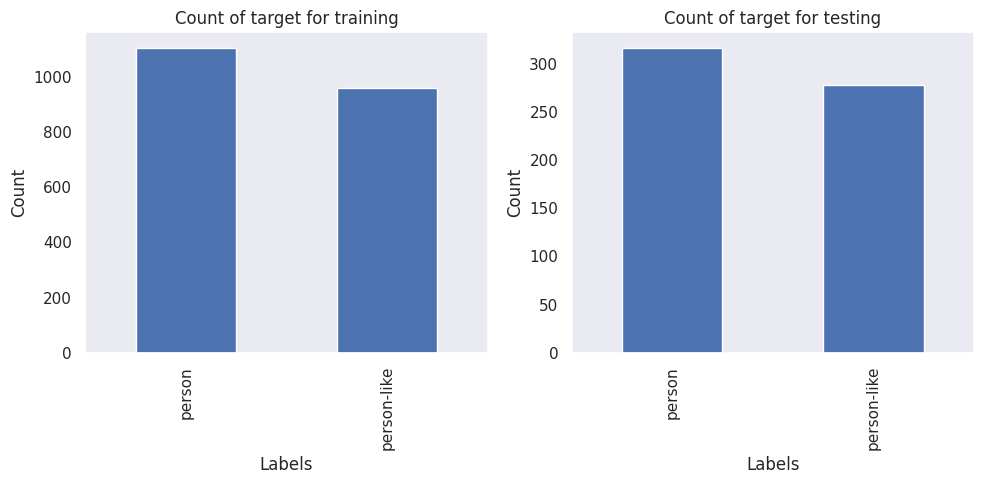

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
train_info['label'].value_counts().plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of target for training')

plt.subplot(1, 2, 2)
test_info['label'].value_counts().plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of target for testing')

plt.tight_layout()
plt.show()


> It 's normally that there are multi objects in specific images so that shape of info 2000 and data 900

**Let's see an example**

In [9]:
train_info.loc[train_info['name']=='image (101)']

,xmin,ymin,xmax,ymax,name,label
4,13,110,213,375,image (101),person
5,149,127,355,375,image (101),person
6,292,61,500,375,image (101),person


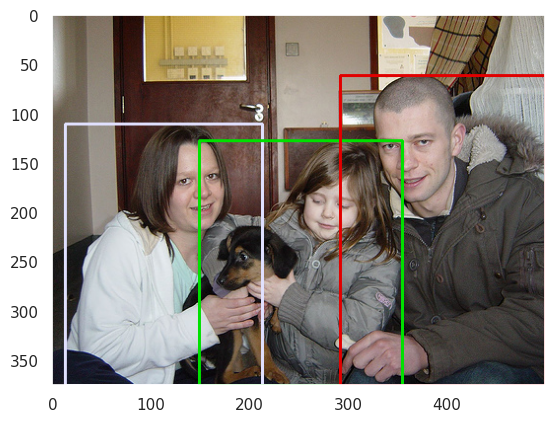

In [10]:
img=cv2.imread(train_path+'/image (101).jpg',cv2.IMREAD_COLOR)
img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGB)

cv2.rectangle(img,(13,110),(213,375),(225,225,255),2)
cv2.rectangle(img,(149,127),(355,375),(0,225,0),2)
cv2.rectangle(img,(292,61),(500,375),(225,0,0),2)

plt.imshow(img)

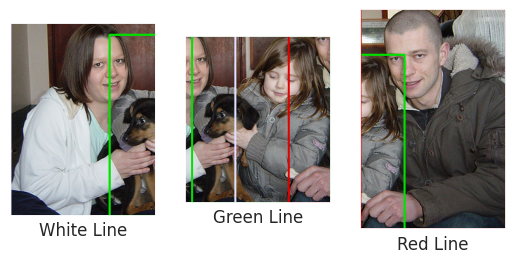

In [11]:
#  y-min, y-max , x-min , x-max
fig=plt.figure()

plt.subplot(1,3,1)
plt.imshow(img[110:375,13:213])
plt.xticks([])
plt.yticks([])
plt.xlabel('White Line')

plt.subplot(1,3,2)
plt.imshow(img[127:375,139:355])
plt.xticks([])
plt.yticks([])
plt.xlabel('Green Line')

plt.subplot(1,3,3)
plt.imshow(img[61:375,292:500])
plt.xticks([])
plt.yticks([])
plt.xlabel('Red Line')

plt.show()

#### So we should splitting objects for the image

In [12]:
def croppingFromImage(path,Data_information):
    cropped_image=[]
    label=[]
    for i in range(0,len(Data_information)):
        img=cv2.imread(path+'/'+Data_information['name'][i]+'.jpg',cv2.IMREAD_COLOR)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img_=img[Data_information['ymin'][i]:Data_information['ymax'][i],Data_information['xmin'][i]:Data_information['xmax'][i]]
        cropped_image.append(img_)

        label.append(Data_information['label'][i])
    return cropped_image , label

In [13]:
trainImage , trainLabel =croppingFromImage(train_path,train_info)
testImage , testLabel =croppingFromImage(test_path,test_info)

valImage,valLabel=croppingFromImage(val_path,val_info)

In [14]:
print(len(trainImage) == len(trainLabel))
print(len(testImage) == len(testLabel))
print(len(valImage) == len(valLabel))



True
True
True


### Let's see the images

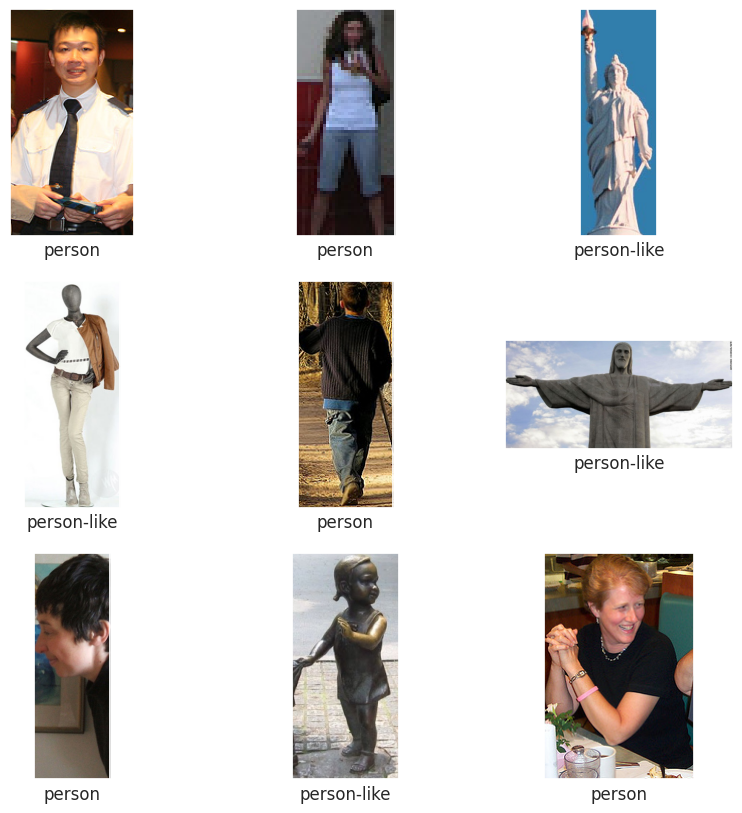

In [15]:
fig=plt.figure(figsize=(10,10))

for i in range (1,10):
    random=np.random.randint(0,len(trainImage))
    plt.subplot(3,3,i)
    plt.imshow(trainImage[random])

    plt.xlabel(trainLabel[random])
    plt.xticks([])
    plt.yticks([])

#### The same in testing

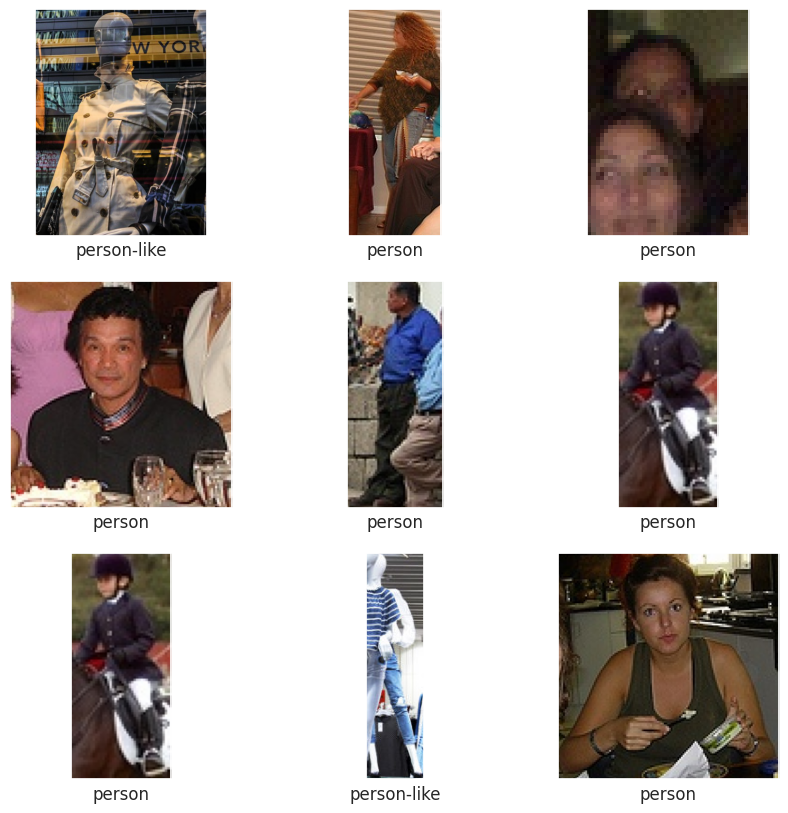

In [16]:
fig=plt.figure(figsize=(10,10))

for i in range (1,10):
    random=np.random.randint(0,len(testImage))
    plt.subplot(3,3,i)
    plt.imshow(testImage[random])
    plt.xlabel(testLabel[random])
    plt.xticks([])
    plt.yticks([])

### As we can see that Data must be reshaped

In [17]:
trainShapes=[]
testShapes=[]
for i in trainImage :
    trainShapes.append(i.shape)
for i in testImage :
    testShapes.append(i.shape)


### Let's see most frequent shapes

In [18]:
pd.Series(trainShapes).value_counts()[:10]

(374, 499, 3)    4
(162, 58, 3)     2
(280, 252, 3)    2
(151, 60, 3)     2
(358, 271, 3)    2
(95, 43, 3)      2
(44, 34, 3)      2
(101, 49, 3)     2
(101, 32, 3)     2
(284, 92, 3)     2
dtype: int64

In [19]:
pd.Series(testShapes).value_counts()[:10]

(85, 52, 3)      2
(128, 58, 3)     2
(128, 47, 3)     2
(120, 37, 3)     2
(171, 74, 3)     2
(105, 81, 3)     2
(506, 449, 3)    1
(225, 128, 3)    1
(180, 94, 3)     1
(187, 85, 3)     1
dtype: int64

### There's observe that cropped objects doesnot has frequent shape and actually this is logical

In [20]:
def resizing(data,size):
    resizing=[]
    for i in data:
        resizing.append(cv2.resize(i,(size,size)))

    return resizing

In [21]:
s=140
X_train,X_test,X_Val=resizing(trainImage,s),resizing(testImage,s),resizing(valImage,s)

In [22]:
labeling=preprocessing.LabelEncoder()
y_train=labeling.fit_transform(trainLabel)
y_test=labeling.fit_transform(testLabel)
y_val=labeling.fit_transform(valLabel)

In [23]:
labeling.classes_

array(['person', 'person-like'], dtype='<U11')

# Feature Extraction

### Here , I will use VGG-16 as a Feature extractor

<img src="https://www.researchgate.net/publication/332412613/figure/fig13/AS:747794327404544@1555299469456/The-VGG-16-architecture-for-the-ImageNet-dataset-26.ppm">

In [24]:
VGG_Model=VGG16(weights='imagenet',include_top=False,input_shape=(s,s,3))

58889256/58889256 [==============================] - 1s 0us/step


In [25]:
for layer in VGG_Model.layers:
    layer.trainable=False



In [26]:
VGG_Model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140, 140, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 140, 140, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 140, 140, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 70, 70, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 70, 70, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 70, 70, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 35, 35, 128)       0     

In [27]:
### Scaling
X_train,X_test,X_Val=np.asarray(X_train).astype(np.float32),np.asarray(X_test).astype(np.float32),np.asarray(X_Val).astype(np.float32)
X_train,X_test,X_Val=X_train/255.0,X_test/255.0,X_Val/255.0

In [28]:
print(X_train.shape)
print(X_test.shape)

(2066, 140, 140, 3)
(595, 140, 140, 3)


In [29]:
Training=np.concatenate((X_train,X_test))
Training_lbl=np.concatenate((y_train,y_test))

In [30]:
print(Training.shape)
print(Training_lbl.shape)

(2661, 140, 140, 3)
(2661,)


In [31]:
features_extracted=VGG_Model.predict(Training)
features_extracted_test=VGG_Model.predict(X_Val)

11/11 [==============================] - 83s 8s/step


In [32]:
flatten=features_extracted.reshape(features_extracted.shape[0],-1)
flatten_test=features_extracted_test.reshape(features_extracted_test.shape[0],-1)

In [33]:
print('train shape before Flatten ',features_extracted.shape)
print('train shape after Flatten ',flatten.shape)
print("="*50)
print('test shape before Flatten ',features_extracted_test.shape)
print('test shape after Flatten ',flatten_test.shape)


train shape before Flatten  (2661, 4, 4, 512)
train shape after Flatten  (2661, 8192)
test shape before Flatten  (333, 4, 4, 512)
test shape after Flatten  (333, 8192)


# Training

In [34]:
model=Sequential()
model.add(Dense(64,input_shape=flatten.shape))
model.add(Activation('relu'))
model.add(Dropout(.7))

model.add(Dense(2))
model.add(Activation('sigmoid'))


In [35]:
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [36]:
print(flatten.shape)
print(Training_lbl.shape)
print(flatten_test.shape)
print(y_val.shape)



(2661, 8192)
(2661,)
(333, 8192)
(333,)


In [37]:
# Reshape flatten and flatten_test
num_samples = flatten.shape[0]
num_time_steps = 1
num_features_per_sample = flatten.shape[1]

flatten = flatten.reshape(num_samples, num_time_steps, num_features_per_sample)
flatten_test = flatten_test.reshape(flatten_test.shape[0], num_time_steps, num_features_per_sample)

# Check the shapes again
print(flatten.shape)
print(flatten_test.shape)


(2661, 1, 8192)
(333, 1, 8192)


In [38]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.metrics import Accuracy

# Define the shape of your input data
num_samples, num_time_steps, num_features = flatten.shape

# Define and compile your model
model = Sequential()
model.add(LSTM(64, input_shape=(num_time_steps, num_features)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Accuracy()])

# Fit the model
fitting = model.fit(flatten, Training_lbl, batch_size=100, epochs=7, validation_data=(flatten_test, y_val))

# Access accuracy during training and validation
train_accuracy = fitting.history['accuracy']
val_accuracy = fitting.history['val_accuracy']



Epoch 1/7
27/27 [==============================] - 6s 98ms/step - loss: 0.6646 - accuracy: 0.0000e+00 - val_loss: 0.5637 - val_accuracy: 0.0000e+00
Epoch 2/7
27/27 [==============================] - 1s 44ms/step - loss: 0.5117 - accuracy: 0.0000e+00 - val_loss: 0.4966 - val_accuracy: 0.0000e+00
Epoch 3/7
27/27 [==============================] - 1s 44ms/step - loss: 0.4414 - accuracy: 0.0000e+00 - val_loss: 0.4449 - val_accuracy: 0.0000e+00
Epoch 4/7
27/27 [==============================] - 1s 46ms/step - loss: 0.3901 - accuracy: 0.0000e+00 - val_loss: 0.4316 - val_accuracy: 0.0000e+00
Epoch 5/7
27/27 [==============================] - 1s 45ms/step - loss: 0.3442 - accuracy: 0.0000e+00 - val_loss: 0.3910 - val_accuracy: 0.0000e+00
Epoch 6/7
27/27 [==============================] - 1s 44ms/step - loss: 0.3056 - accuracy: 0.0000e+00 - val_loss: 0.3675 - val_accuracy: 0.0000e+00
Epoch 7/7
27/27 [==============================] - 1s 44ms/step - loss: 0.2702 - accuracy: 0.0000e+00 - val_loss

In [39]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the shape of your input data
num_samples, num_time_steps, num_features = flatten.shape

# Define your model
model = Sequential()
model.add(LSTM(64, input_shape=(num_time_steps, num_features)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with accuracy metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
fitting = model.fit(flatten, Training_lbl, batch_size=100, epochs=7, validation_data=(flatten_test, y_val))

# Access accuracy during training and validation
train_accuracy = fitting.history['accuracy']
val_accuracy = fitting.history['val_accuracy']


Epoch 1/7
27/27 [==============================] - 4s 67ms/step - loss: 0.4504 - accuracy: 0.7753 - val_loss: 0.3124 - val_accuracy: 0.8468
Epoch 2/7
27/27 [==============================] - 2s 66ms/step - loss: 0.2807 - accuracy: 0.8869 - val_loss: 0.3064 - val_accuracy: 0.8709
Epoch 3/7
27/27 [==============================] - 2s 73ms/step - loss: 0.1977 - accuracy: 0.9297 - val_loss: 0.3066 - val_accuracy: 0.8559
Epoch 4/7
27/27 [==============================] - 2s 63ms/step - loss: 0.1449 - accuracy: 0.9545 - val_loss: 0.2655 - val_accuracy: 0.8679
Epoch 5/7
27/27 [==============================] - 1s 44ms/step - loss: 0.0939 - accuracy: 0.9786 - val_loss: 0.3142 - val_accuracy: 0.8559
Epoch 6/7
27/27 [==============================] - 1s 45ms/step - loss: 0.0684 - accuracy: 0.9876 - val_loss: 0.2939 - val_accuracy: 0.8679
Epoch 7/7
27/27 [==============================] - 1s 45ms/step - loss: 0.0508 - accuracy: 0.9917 - val_loss: 0.3092 - val_accuracy: 0.8739


# Evaluation

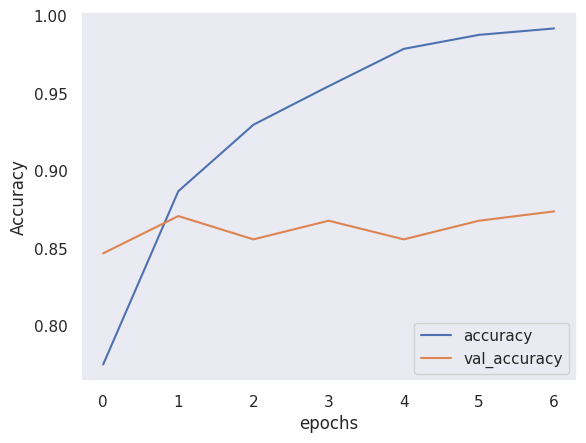

In [40]:
plt.plot(fitting.history['accuracy'])
plt.plot(fitting.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['accuracy','val_accuracy'],loc='lower right')
plt.show()

In [41]:
pred=model.predict(flatten_test)

11/11 [==============================] - 0s 7ms/step


In [42]:
def conver(prediction):
    if prediction <= 0.5:
        return 'person'
    else:
        return 'Not person'

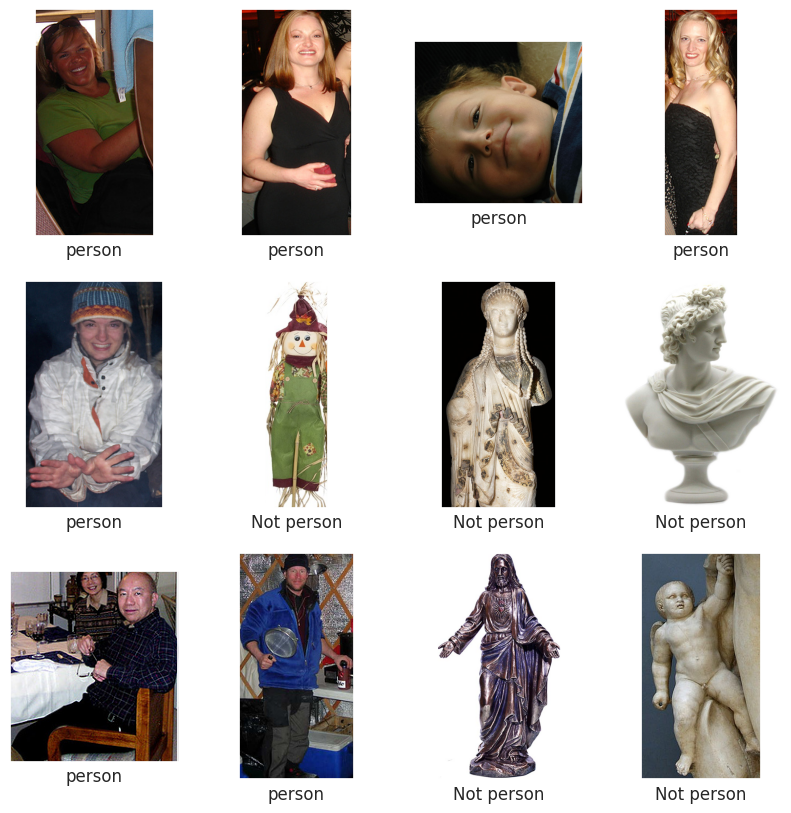

In [44]:
fig=plt.figure(figsize=(10,10))

for i in range (1,13):
    random=np.random.randint(0,len(valImage))
    plt.subplot(3,4,i)
    plt.imshow(valImage[random])
    label=conver(pred[random])
    plt.xlabel(label)
    plt.xticks([])
    plt.yticks([])